In [1]:
# Load NeuroKit and other useful packages
%matplotlib widget


import neurokit2 as nk

import numpy as np 
import pandas as pd
import os

import csv
import itertools
import collections
import pywt

from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [3]:
path = '../Fractal Analysis/mitbih_database//mitbih_database/'
window_size = 160
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [4]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()



In [5]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)




Data Extraction and Preprocessing


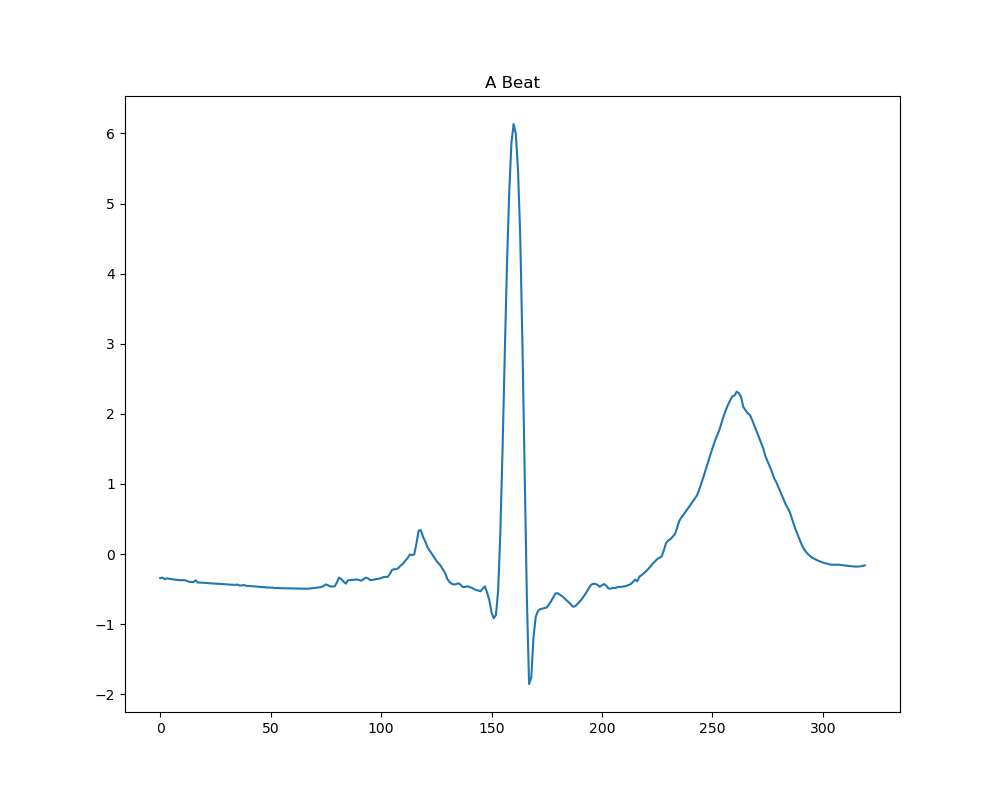

(100016, 320) (100016,)


In [6]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " Wave")
        #plt.plot(signals[0:700])
        #plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " wave after denoised")
        #plt.plot(signals[0:700])
        #plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " wave after z-score normalization ")
        #plt.plot(signals[0:700])
        #plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.figure(figsize=(10,8))
                        plt.title("A Beat")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

2


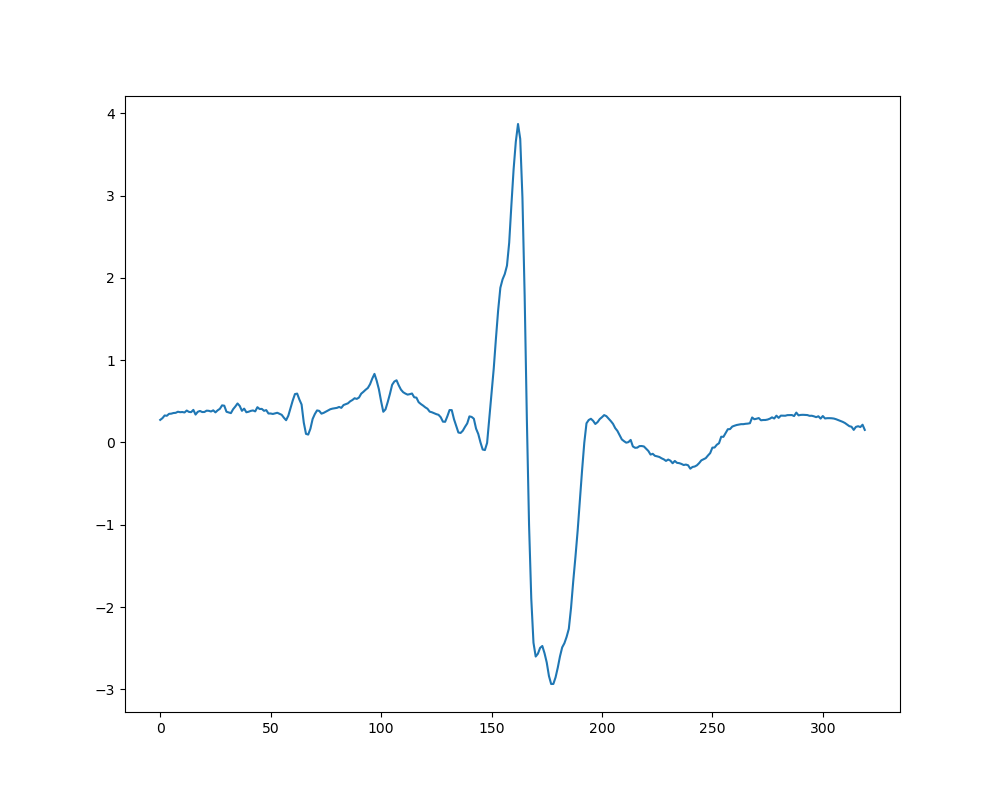

In [7]:
plt.figure(figsize=(10,8))
plt.plot(X[30100])
print(y[30100])

In [8]:
count_classes

[75052, 8075, 7259, 2546, 7130]

In [9]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100016, 321)


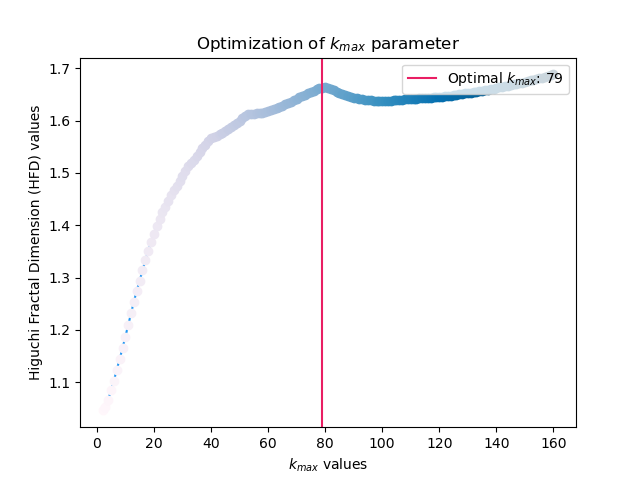

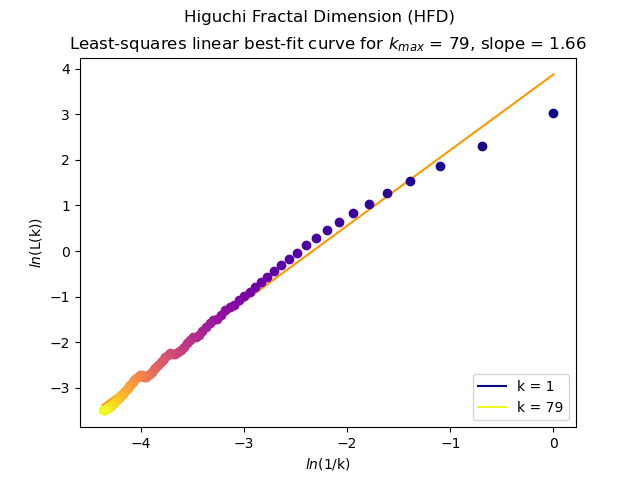

In [10]:
k_max, info =  nk.complexity_k(X[7], k_max='default', show=True)

hfd, info = nk.fractal_higuchi(X[7], k_max=k_max, show=True)


0.0    75015
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 320, dtype: int64


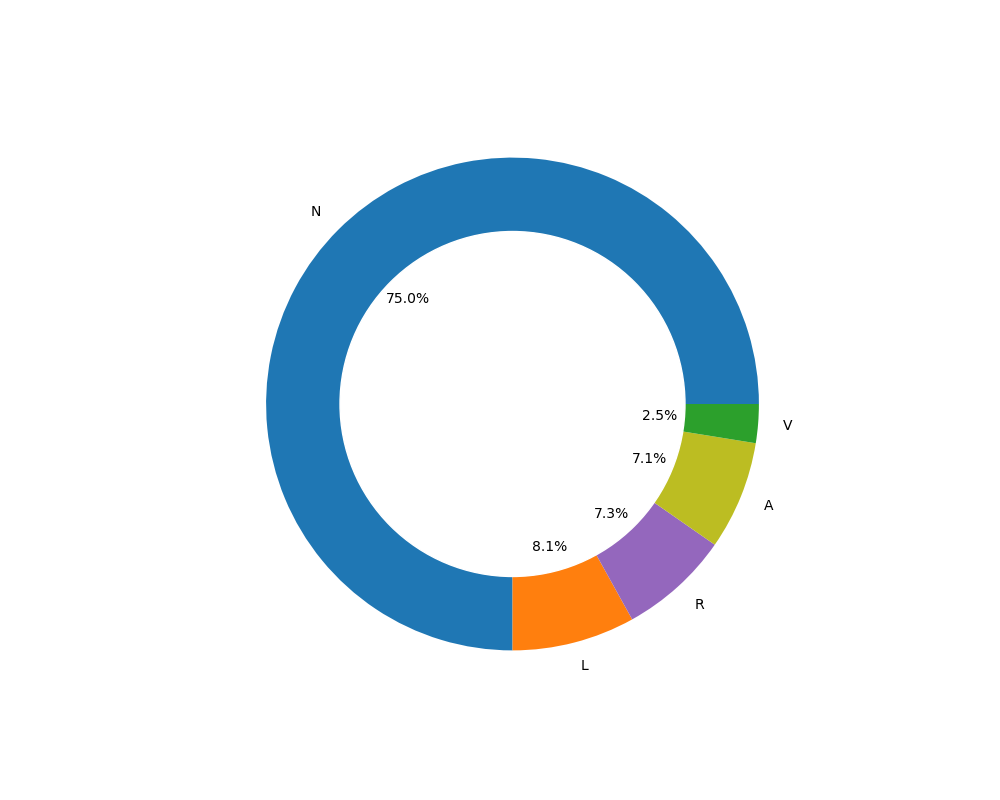

In [11]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Rebalancing Classes

In [12]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 320, dtype: int64


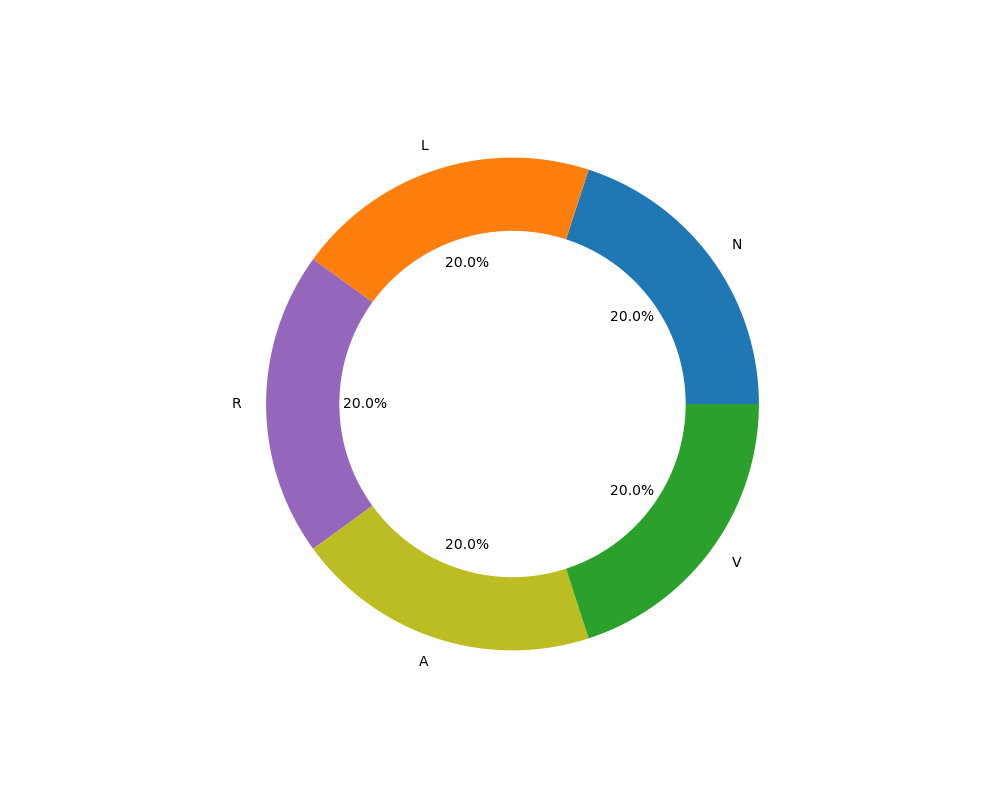

In [13]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [14]:
per_class

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 320, dtype: int64

In [66]:
X_train_df = X_train_df.iloc[: , :-1]
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
59186,-0.254715,-0.270753,-0.167196,-0.021486,0.009363,-0.010336,0.010390,-0.014690,0.066862,-0.121582,...,-0.043844,-0.061446,-0.031643,-0.071650,-0.075833,-0.082121,-0.091430,-0.095677,-0.102803,-0.109033
58629,0.575804,0.568762,0.559688,0.542016,0.520491,0.495039,0.465671,0.446313,0.413036,0.389862,...,0.006569,0.029008,0.050094,0.092615,0.045616,-0.008566,-0.014315,0.004940,0.040263,0.037002
83563,-0.413186,-0.345284,-0.244411,-0.171639,-0.038484,0.098163,0.251617,0.395660,0.423763,0.421312,...,-0.679589,-0.668138,-0.735290,-0.835996,-0.939371,-1.049496,-1.163195,-1.273324,-1.369526,-1.454217
25693,-0.477686,-0.462402,-0.447063,-0.426353,-0.403748,-0.384641,-0.366544,-0.344644,-0.324860,-0.304241,...,-1.169584,-1.193618,-1.217063,-1.240018,-1.262189,-1.282598,-1.301719,-1.320388,-1.338075,-1.353749
32034,-0.135638,-0.133801,-0.133726,-0.139770,-0.142445,-0.145179,-0.148998,-0.152765,-0.154845,-0.155763,...,-0.208741,-0.200898,-0.196186,-0.186350,-0.218096,-0.196825,-0.202887,-0.203406,-0.218122,-0.216660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62577,-0.396738,-0.407132,-0.408455,-0.409901,-0.412390,-0.418704,-0.412212,-0.403680,-0.443922,-0.401792,...,-0.087703,-0.085602,-0.086959,-0.094638,-0.071717,-0.089133,-0.086605,-0.090831,-0.075716,-0.095683
43813,-0.015512,0.023468,0.049631,0.078294,0.077537,0.069895,0.097026,0.129967,0.159551,0.148816,...,0.124870,0.119975,0.150738,0.131687,0.139335,0.145054,0.148850,0.151485,0.154639,0.157573
55929,0.809013,1.064941,1.403971,1.725946,2.090258,2.586043,3.128772,3.768961,4.343389,4.714972,...,-0.389592,-0.386575,-0.383577,-0.380396,-0.377161,-0.374135,-0.371177,-0.368006,-0.364950,-0.361813
79933,-0.180190,-0.193850,-0.206816,-0.255565,-0.291154,-0.378596,-0.336949,-0.330031,-0.354611,-0.365400,...,0.120167,0.126741,0.133249,0.138305,0.137296,0.161618,0.164197,0.144573,0.166394,0.184694


In [67]:
beatdata = X_train_df.to_numpy()

0.9248331577844936

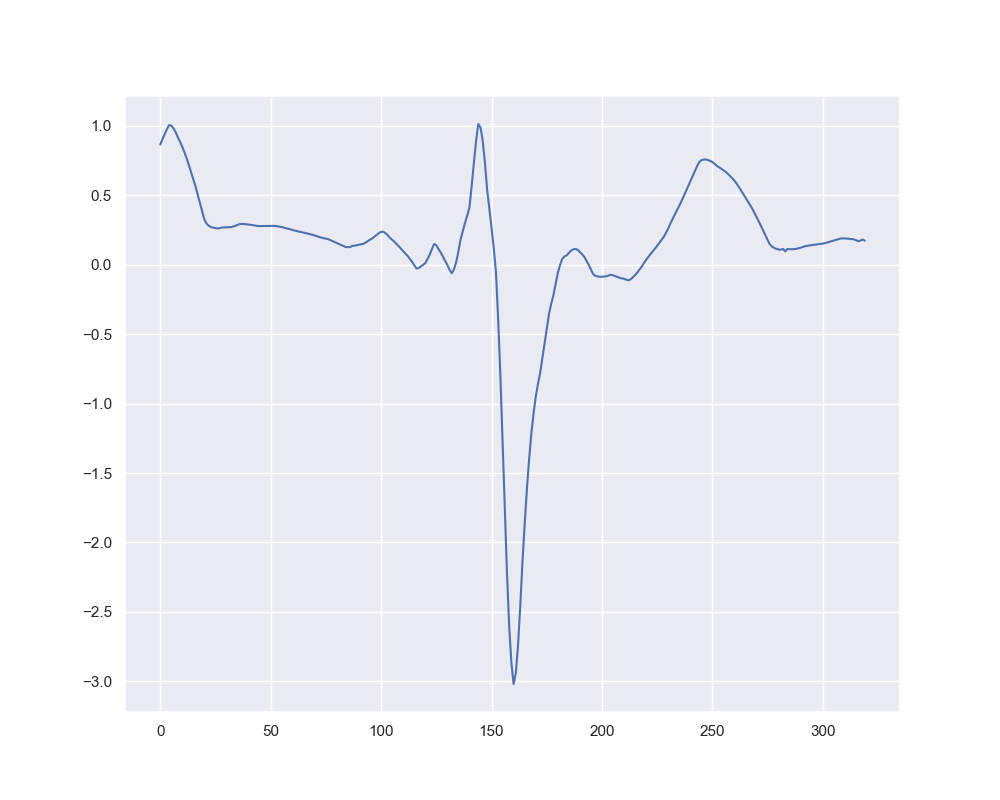

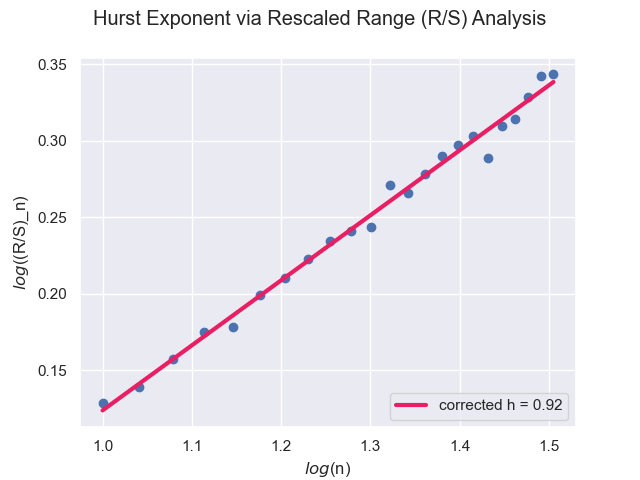

In [68]:
fig = plt.figure(figsize=(10,8))
plt.plot(beatdata[23000])

#k_max, info =  nk.complexity_k(beatdata[100], k_max='default', show=True)
#hfd, info = nk.fractal_higuchi(beatdata[100], k_max=k_max, show=True)

h, info = nk.fractal_hurst(beatdata[23000], corrected=True, show=True)
h

plt.plot(beatdata[6000])
k_max, info =  nk.complexity_k(beatdata[6000], k_max='default', show=False)

hfd, info = nk.fractal_higuchi(beatdata[6000], k_max=k_max, show=False)


plt.plot(beatdata[11000])
k_max, info =  nk.complexity_k(beatdata[11000], k_max='default', show=False)

hfd, info = nk.fractal_higuchi(beatdata[11000], k_max=k_max, show=False)

plt.plot(beatdata[16000])
k_max, info =  nk.complexity_k(beatdata[16000], k_max='default', show=False)

hfd, info = nk.fractal_higuchi(beatdata[16000], k_max=k_max, show=False)

In [69]:
fdim0 = np.zeros(100)
h0 = np.zeros(100)
cd0 = np.zeros(100)
lle0 = np.zeros(100)

for i in range(0,100):
    k_max, info =  nk.complexity_k(beatdata[1000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[1000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[1000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[1000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    fdim0[i] = hfd
    h0[i] = h
    cd0[i] = cd
    lle0[i] = lle
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [70]:
fdim1 = np.zeros(100)
h1 = np.zeros(100)
cd1 = np.zeros(100)
lle1 = np.zeros(100)

for i in range(0,100):
    k_max, info =  nk.complexity_k(beatdata[6000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[6000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[6000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[6000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[6000+i], method="rosenstein1993", show=False)


    fdim1[i] = hfd
    h1[i] = h
    cd1[i] = cd
    lle1[i] = lle
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [71]:
fdim2 = np.zeros(100)
h2 = np.zeros(100)
cd2 = np.zeros(100)
lle2 = np.zeros(100)

for i in range(0,100):
    k_max, info =  nk.complexity_k(beatdata[11000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[11000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[11000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[11000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[11000+i], method="rosenstein1993", show=False)


    fdim2[i] = hfd
    h2[i] = h
    cd2[i] = cd
    lle2[i] = lle
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [72]:
fdim3 = np.zeros(100)
h3 = np.zeros(100)
cd3 = np.zeros(100)
lle3 = np.zeros(100)

for i in range(0,100):
    k_max, info =  nk.complexity_k(beatdata[16000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[16000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[16000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[16000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[16000+i], method="rosenstein1993", show=False)


    fdim3[i] = hfd
    h3[i] = h
    cd3[i] = cd
    lle3[i] = lle
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [73]:
#plt.plot(beatdata[21000])

fdim4 = np.zeros(100)
h4 = np.zeros(100)
cd4 = np.zeros(100)
lle4 = np.zeros(100)

for i in range(0,100):
    k_max, info =  nk.complexity_k(beatdata[22000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[22000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[22000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[22000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[22000+i], method="rosenstein1993", show=False)

    
    fdim4[i] = hfd
    h4[i] = h
    cd4[i] = cd
    lle4[i] = lle
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


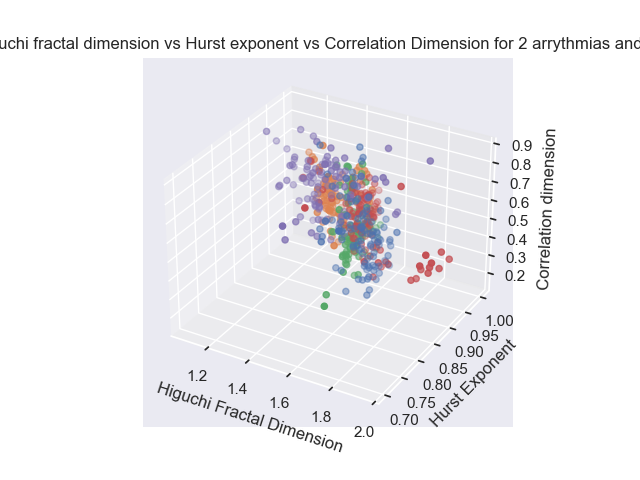

In [74]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(fdim0, h0, cd0)
ax.scatter(fdim1, h1, cd1)
ax.scatter(fdim2, h2, cd2)
ax.scatter(fdim3, h3, cd3)
ax.scatter(fdim4, h4, cd4)

ax.set_xlabel('Higuchi Fractal Dimension')
ax.set_ylabel('Hurst Exponent')
ax.set_zlabel('Correlation dimension')
#ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias")
ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias and NSR")

plt.show()



fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(fdim1, h1, cd1)
ax.scatter(fdim2, h2, cd2)

ax.set_xlabel('Higuchi Fractal Dimension')
ax.set_ylabel('Hurst Exponent')
ax.set_zlabel('Correlation dimension')
ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias")

ax.view_init(80, 90)



In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Ndim = np.insert(np.stack((fdim0, h0, cd0, lle0), axis = 1),0,0, axis=1)    #0
Ldim = np.insert(np.stack((fdim1, h1, cd1,lle1), axis = 1),0,1, axis=1)     #1
Rdim = np.insert(np.stack((fdim2, h2, cd2, lle2), axis = 1),0,2, axis=1)    #2
Adim = np.insert(np.stack((fdim3, h3, cd3, lle3), axis = 1),0,3, axis=1)    #3
Vdim = np.insert(np.stack((fdim4, h4, cd4, lle4), axis = 1),0,4, axis=1)    #4

labels  = np.array(np.concatenate((Ndim[:, 0], Ldim[:, 0], Rdim[:, 0], Adim[:, 0], Vdim[:, 0])), dtype=object)
Xfdim   = np.array(np.concatenate((Ndim[:, 1], Ldim[:, 1], Rdim[:, 1], Adim[:, 1], Vdim[:, 1])), dtype=object)
Xh      = np.array(np.concatenate((Ndim[:, 2], Ldim[:, 2], Rdim[:, 2], Adim[:, 2], Vdim[:, 2])), dtype=object)
Xcd     = np.array(np.concatenate((Ndim[:, 3], Ldim[:, 3], Rdim[:, 3], Adim[:, 3], Vdim[:, 3])), dtype=object)
Xlle    = np.array(np.concatenate((Ndim[:, 4], Ldim[:, 4], Rdim[:, 4], Adim[:, 4], Vdim[:, 4])), dtype=object)


#Ndim[:, 4], Ldim[:, 4],  Rdim[:, 4], Adim[:, 4], Vdim[:, 4]


X = np.stack((labels, Xfdim, Xh, Xcd, Xlle), axis =1)




names = ['Type', 'FD', "Hurst", 'CD', 'LLE']
labels_df = X[:, 0]

df = pd.DataFrame(X, columns = names)

standardized_data = StandardScaler().fit_transform(df)
data_500 = standardized_data



pca = PCA(n_components=3)
#Npca = pca.fit_transform(Ndim)
#Lpca = pca.fit_transform(Ldim)
#Rpca = pca.fit_transform(Rdim)
#Apca = pca.fit_transform(Adim)
#Vpca = pca.fit_transform(Vdim)




c:\Users\Matt Segue\anaconda3\envs\neurokit\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


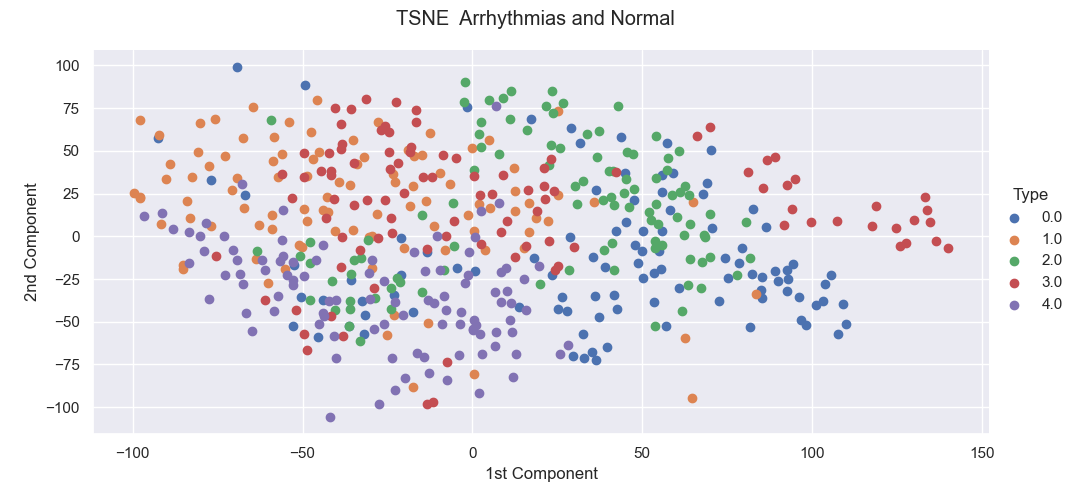

,1st Component,2nd Component,3rd Component,Type
0,92.67749,-19.683897,-47.632896,0.0
1,109.137756,-39.497028,-46.44381,0.0
2,59.232533,37.271996,-73.973892,0.0
3,68.97673,31.09516,-66.486244,0.0
4,84.977844,-31.18428,0.180479,0.0
...,...,...,...,...
495,-13.873908,-20.403633,93.402054,4.0
496,11.098925,-48.887276,95.734268,4.0
497,0.99439,-51.903652,129.088196,4.0
498,25.838324,-68.689095,102.939072,4.0


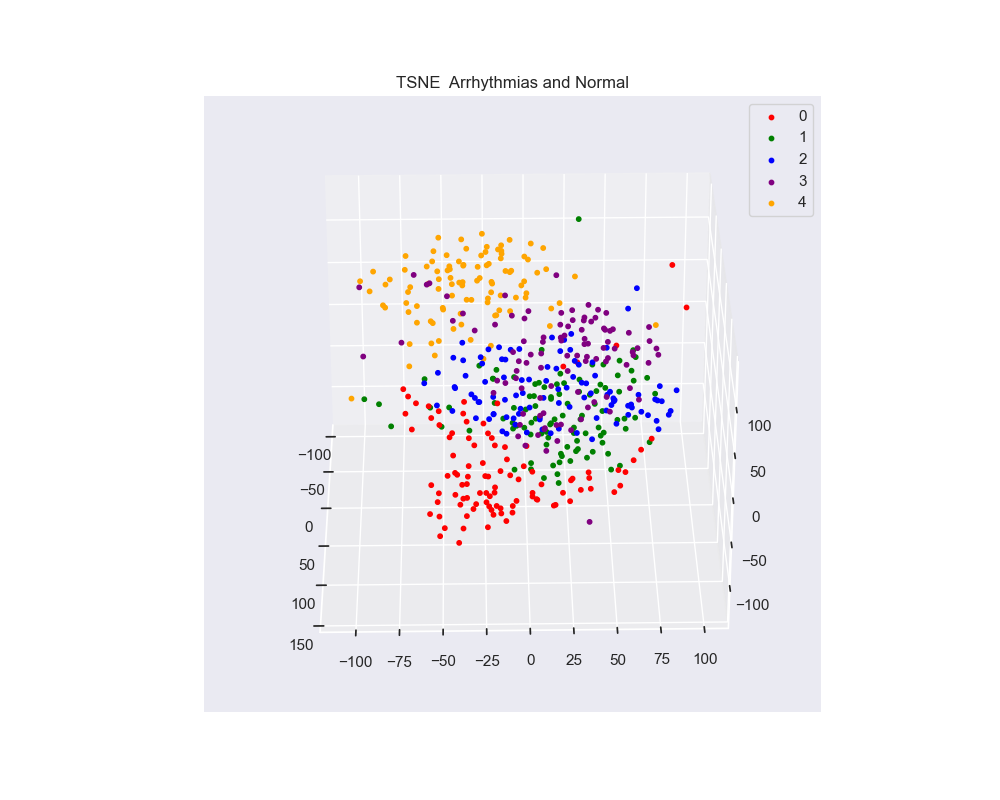

In [76]:
from code import interact
from tkinter import Y
from sklearn.manifold import TSNE
import seaborn as sn
from mpl_toolkits.mplot3d import axes3d 



tsne = TSNE(n_components=3,  random_state=0, perplexity=20,early_exaggeration=6, n_iter=2000, learning_rate = 600, n_iter_without_progress=300, angle=0.5)
labels_500 = labels_df
Xtsne = tsne.fit_transform(data_500)

tsne_data = np.vstack((Xtsne.T, labels_500)).T


tsne_data

sn.set(style = "darkgrid")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')


#3 Components
tsne_df = pd.DataFrame(tsne_data, columns = ('1st Component', '2nd Component', '3rd Component','Type'))

#2 Components
#tsne_df = pd.DataFrame(tsne_data, columns = ('1st Component', '2nd Component', '3rd Component','Type'))


sn.FacetGrid(tsne_df, hue = 'Type', aspect = 2, height = 5).map(plt.scatter, '1st Component', '2nd Component').add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle('TSNE  Arrhythmias and Normal ')

x = tsne_df["1st Component"].to_numpy()
y = tsne_df["2nd Component"].to_numpy()
z = tsne_df["3rd Component"].to_numpy()

#Plotting n=3 Components
ax.scatter(x[:100],    y[:100],    z[:100],    s=10,   c = 'red', cmap=plt.cm.prism, label = 0, alpha = 1)          #0
ax.scatter(x[100:200], y[100:200], z[100:200], s = 10, c = 'green', cmap=plt.cm.prism, label = 1, alpha = 1)        #1
ax.scatter(x[200:300], y[200:300], z[200:300], s = 10, c = 'blue', cmap=plt.cm.prism, label = 2, alpha = 1)         #2
ax.scatter(x[300:400], y[300:400], z[300:400], s = 10, c = 'purple', cmap=plt.cm.prism, label = 3, alpha = 1)       #3
ax.scatter(x[400:500], y[400:500], z[400:500], s = 10, c = 'orange', cmap=plt.cm.prism, label = 4, alpha = 1)       #4


#Plotting n=2 Components
#ax.scatter(x[:200],y[:200], s=10, c = 'red', cmap=plt.cm.prism, label = 0, alpha = 1)                   #0
#ax.scatter(x[200:400], y[200:400], s = 10, c = 'green', cmap=plt.cm.prism, label = 1, alpha = 1)        #1
#ax.scatter(x[400:600], y[400:600], s = 10, c = 'blue', cmap=plt.cm.prism, label = 2, alpha = 1)         #2
#ax.scatter(x[600:800],y[600:800], s = 10, c = 'purple', cmap=plt.cm.prism, label = 3, alpha = 1)        #3
#ax.scatter(x[800:1000],y[800:1000], s = 10, c = 'orange', cmap=plt.cm.prism, label = 4, alpha = 1)      #4

#z[:100]

ax.legend()
ax.set_title('TSNE  Arrhythmias and Normal')



for angle in range(0, 360):
   ax.view_init(30, angle)
  


plt.show()

tsne_df



In [77]:
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
59186,-0.254715,-0.270753,-0.167196,-0.021486,0.009363,-0.010336,0.010390,-0.014690,0.066862,-0.121582,...,-0.043844,-0.061446,-0.031643,-0.071650,-0.075833,-0.082121,-0.091430,-0.095677,-0.102803,-0.109033
58629,0.575804,0.568762,0.559688,0.542016,0.520491,0.495039,0.465671,0.446313,0.413036,0.389862,...,0.006569,0.029008,0.050094,0.092615,0.045616,-0.008566,-0.014315,0.004940,0.040263,0.037002
83563,-0.413186,-0.345284,-0.244411,-0.171639,-0.038484,0.098163,0.251617,0.395660,0.423763,0.421312,...,-0.679589,-0.668138,-0.735290,-0.835996,-0.939371,-1.049496,-1.163195,-1.273324,-1.369526,-1.454217
25693,-0.477686,-0.462402,-0.447063,-0.426353,-0.403748,-0.384641,-0.366544,-0.344644,-0.324860,-0.304241,...,-1.169584,-1.193618,-1.217063,-1.240018,-1.262189,-1.282598,-1.301719,-1.320388,-1.338075,-1.353749
32034,-0.135638,-0.133801,-0.133726,-0.139770,-0.142445,-0.145179,-0.148998,-0.152765,-0.154845,-0.155763,...,-0.208741,-0.200898,-0.196186,-0.186350,-0.218096,-0.196825,-0.202887,-0.203406,-0.218122,-0.216660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62577,-0.396738,-0.407132,-0.408455,-0.409901,-0.412390,-0.418704,-0.412212,-0.403680,-0.443922,-0.401792,...,-0.087703,-0.085602,-0.086959,-0.094638,-0.071717,-0.089133,-0.086605,-0.090831,-0.075716,-0.095683
43813,-0.015512,0.023468,0.049631,0.078294,0.077537,0.069895,0.097026,0.129967,0.159551,0.148816,...,0.124870,0.119975,0.150738,0.131687,0.139335,0.145054,0.148850,0.151485,0.154639,0.157573
55929,0.809013,1.064941,1.403971,1.725946,2.090258,2.586043,3.128772,3.768961,4.343389,4.714972,...,-0.389592,-0.386575,-0.383577,-0.380396,-0.377161,-0.374135,-0.371177,-0.368006,-0.364950,-0.361813
79933,-0.180190,-0.193850,-0.206816,-0.255565,-0.291154,-0.378596,-0.336949,-0.330031,-0.354611,-0.365400,...,0.120167,0.126741,0.133249,0.138305,0.137296,0.161618,0.164197,0.144573,0.166394,0.184694


Declare feature vector and target variable

In [198]:
X = df.drop(['Type'], axis=1)
X = X.drop(['LLE'], axis =1)
#X = X.drop(['Hurst'], axis =1)
#X = X.drop(['CD'], axis =1)

y = df['Type'].astype('int')


In [199]:
X

,FD,Hurst,CD
0,1.621469,0.890577,0.256264
1,1.558253,0.864194,0.211146
2,1.559003,0.965066,0.301919
3,1.613278,0.967146,0.312168
4,1.521402,0.872489,0.300277
...,...,...,...
495,1.281677,0.929816,0.524474
496,1.315843,0.928127,0.519302
497,1.291537,0.949499,0.629825
498,1.309136,0.9407,0.400709


Split data into separate training and test set 


In [200]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [201]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((400, 3), (100, 3))

Feature Scaling

In [202]:
cols = X_train.columns

In [203]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [204]:
X_train = pd.DataFrame(X_train, columns=[cols])


In [205]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [206]:
X_train.describe()

,FD,Hurst,CD
count,4.000000e+02,4.000000e+02,4.000000e+02
mean,-1.239897e-14,-7.784884e-15,1.048051e-15
std,1.001252e+00,1.001252e+00,1.001252e+00
min,-3.018023e+00,-6.490805e+00,-2.468695e+00
25%,-6.066632e-01,-4.338518e-01,-7.567192e-01
50%,8.807557e-02,8.323404e-02,-8.767018e-02
75%,4.584187e-01,6.620113e-01,7.775430e-01
max,3.634398e+00,1.923727e+00,2.411006e+00


Run SVM  


In [217]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


#rbf svc
svc=SVC(C=160.0) 

#polynomial svc
#poly_svc=SVC(kernel='poly', C=4000) 

#sigmoid svc
#sigmoid_svc=SVC(kernel='sigmoid', C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=160.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=160.0 : 0.6700


Compare the train-set and test-set accuracy

In [218]:
y_pred_train = svc.predict(X_train)



In [219]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.7750


Check for overfitting and underfitting

In [220]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

Training set score: 0.7750
Test set score: 0.6700


In [221]:
# check class distribution in test set

y_test.value_counts()

3    25
2    21
1    19
4    18
0    17
Name: Type, dtype: int64

In [222]:
# check null accuracy score

null_accuracy = (25/(100))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.2500


Confusion matrix 

In [223]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

#print('Confusion matrix\n\n', cm)

#print('\nTrue Positives(TP) = ', cm[0,0])

#print('\nTrue Negatives(TN) = ', cm[1,1])

#print('\nFalse Positives(FP) = ', cm[0,1])

#print('\nFalse Negatives(FN) = ', cm[1,0])

Text(0.5, 1.0, 'Confusion Matrix')

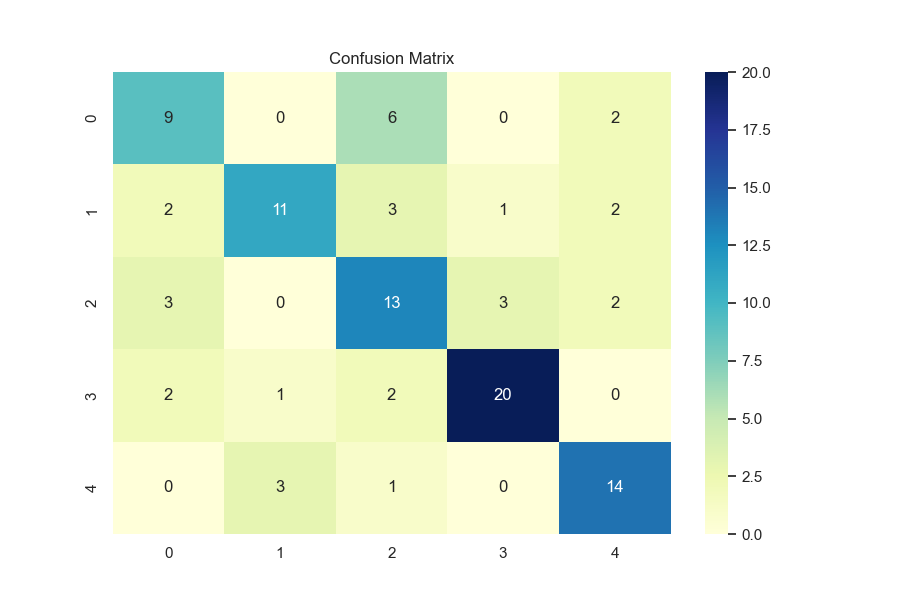

In [227]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['0', '1', '2', '3', '4'], 
                                 index=['0', '1', '2', '3', '4'])

f, ax = plt.subplots(figsize=(9, 6))
g = sn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('Confusion Matrix')
